Depth map shape: (3200, 1, 1600)


TypeError: Invalid shape (3200, 1, 1600) for image data

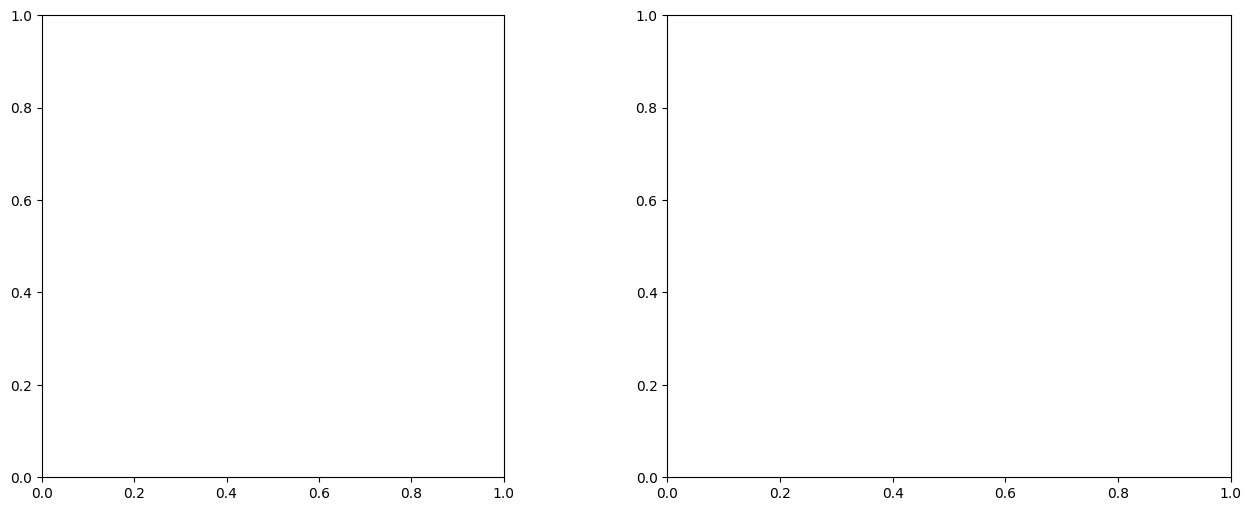

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import struct

def read_dmb(filepath):
    """Read .dmb depth map file"""
    with open(filepath, 'rb') as f:
        # Read header
        height = struct.unpack('i', f.read(4))[0]
        width = struct.unpack('i', f.read(4))[0]
        channels = struct.unpack('i', f.read(4))[0]
        
        # Read depth data
        num_values = height * width * channels
        depth_data = struct.unpack('f' * num_values, f.read(4 * num_values))
        depth_map = np.array(depth_data).reshape((channels, height, width))
        
        # If single channel, squeeze it to (H, W)
        if channels == 1:
            depth_map = depth_map.squeeze(0)
            
    return depth_map

# Load and visualize
depth = read_dmb('/home/kanao/sahil/ACMMP-Spherical/mahinedra_new/ACMMP/2333_00000028/depths.dmb')

print(f"Depth map shape: {depth.shape}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw depth
im1 = axes[0].imshow(depth, cmap='turbo')
axes[0].set_title('Depth Map (Raw)')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], label='Depth')

# Inverse depth (better for visualization)
valid_mask = depth > 0
inv_depth = np.zeros_like(depth)
inv_depth[valid_mask] = 1.0 / depth[valid_mask]

im2 = axes[1].imshow(inv_depth, cmap='viridis')
axes[1].set_title('Inverse Depth (closer = brighter)')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], label='Inverse Depth')

plt.tight_layout()
plt.show()

print(f"Depth range: {depth[valid_mask].min():.3f} - {depth[valid_mask].max():.3f}")

TypeError: Invalid shape (1, 1600, 3200) for image data

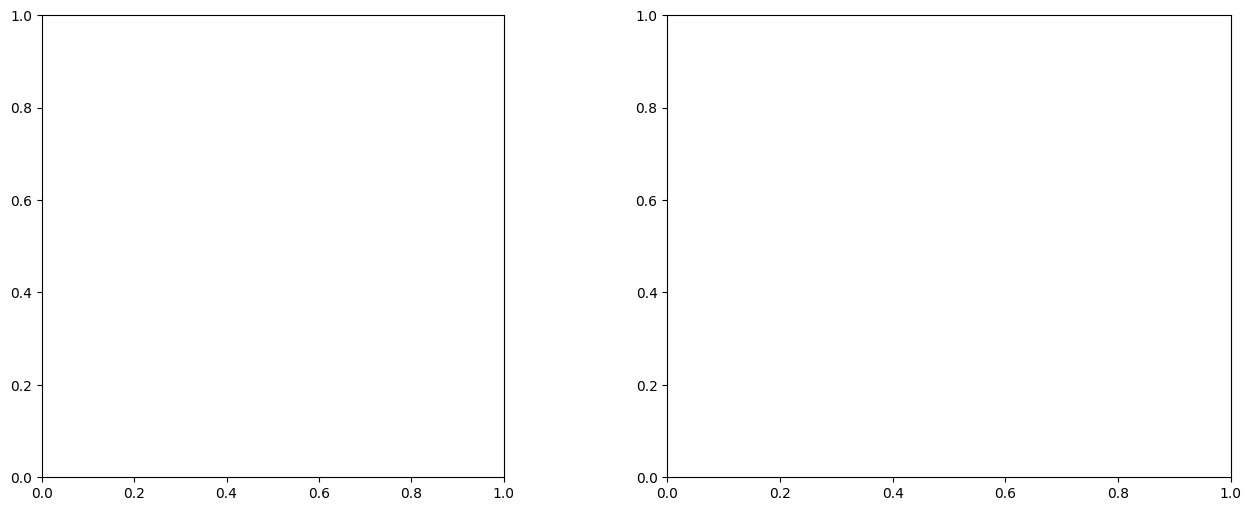

In [2]:

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw depth
im1 = axes[0].imshow(depth, cmap='turbo')
axes[0].set_